# Calibration
[OpenCV docs](https://docs.opencv.org/4.x/da/d13/tutorial_aruco_calibration.html)

In [1]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle

%matplotlib inline

## Draw charuco board

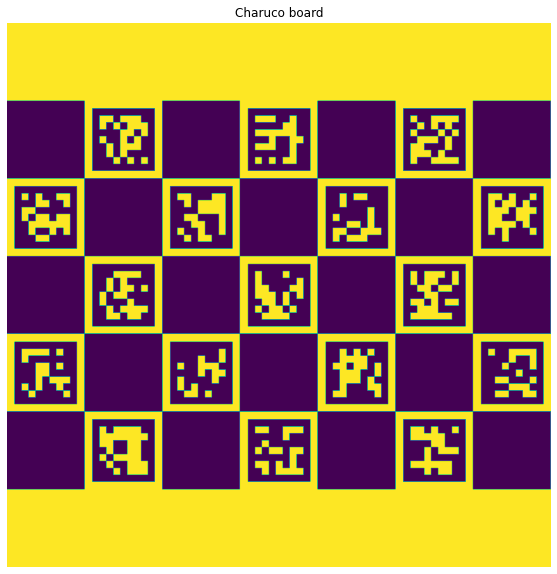

In [2]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_7X7_50)
board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
imboard = board.draw((2000, 2000))
# cv2.imshow("image", imboard)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard)
plt.title('Charuco board')
ax.axis('off')

plt.show()

## Prepare data

In [3]:
datadir_L = "./calib_cam/left/"
images_L = np.array([datadir_L + f for f in os.listdir(datadir_L) if f.endswith(".png") ])
order = np.argsort([int(p.split(".")[1].split("/")[-1]) for p in images_L])
images_L = images_L[order]
print(len(images_L))
images_L

46


array(['./calib_cam/left/0.png', './calib_cam/left/1.png',
       './calib_cam/left/2.png', './calib_cam/left/3.png',
       './calib_cam/left/4.png', './calib_cam/left/5.png',
       './calib_cam/left/6.png', './calib_cam/left/7.png',
       './calib_cam/left/8.png', './calib_cam/left/9.png',
       './calib_cam/left/10.png', './calib_cam/left/11.png',
       './calib_cam/left/12.png', './calib_cam/left/13.png',
       './calib_cam/left/14.png', './calib_cam/left/15.png',
       './calib_cam/left/16.png', './calib_cam/left/17.png',
       './calib_cam/left/18.png', './calib_cam/left/19.png',
       './calib_cam/left/20.png', './calib_cam/left/21.png',
       './calib_cam/left/22.png', './calib_cam/left/23.png',
       './calib_cam/left/24.png', './calib_cam/left/25.png',
       './calib_cam/left/26.png', './calib_cam/left/27.png',
       './calib_cam/left/28.png', './calib_cam/left/29.png',
       './calib_cam/left/30.png', './calib_cam/left/31.png',
       './calib_cam/left/32.png', 

In [4]:
datadir_R = "./calib_cam/right/"
images_R = np.array([datadir_R + f for f in os.listdir(datadir_R) if f.endswith(".png") ])
order = np.argsort([int(p.split(".")[1].split("/")[-1]) for p in images_R])
images_R = images_R[order]
print(len(images_R))
images_R

46


array(['./calib_cam/right/0.png', './calib_cam/right/1.png',
       './calib_cam/right/2.png', './calib_cam/right/3.png',
       './calib_cam/right/4.png', './calib_cam/right/5.png',
       './calib_cam/right/6.png', './calib_cam/right/7.png',
       './calib_cam/right/8.png', './calib_cam/right/9.png',
       './calib_cam/right/10.png', './calib_cam/right/11.png',
       './calib_cam/right/12.png', './calib_cam/right/13.png',
       './calib_cam/right/14.png', './calib_cam/right/15.png',
       './calib_cam/right/16.png', './calib_cam/right/17.png',
       './calib_cam/right/18.png', './calib_cam/right/19.png',
       './calib_cam/right/20.png', './calib_cam/right/21.png',
       './calib_cam/right/22.png', './calib_cam/right/23.png',
       './calib_cam/right/24.png', './calib_cam/right/25.png',
       './calib_cam/right/26.png', './calib_cam/right/27.png',
       './calib_cam/right/28.png', './calib_cam/right/29.png',
       './calib_cam/right/30.png', './calib_cam/right/31.png',
  

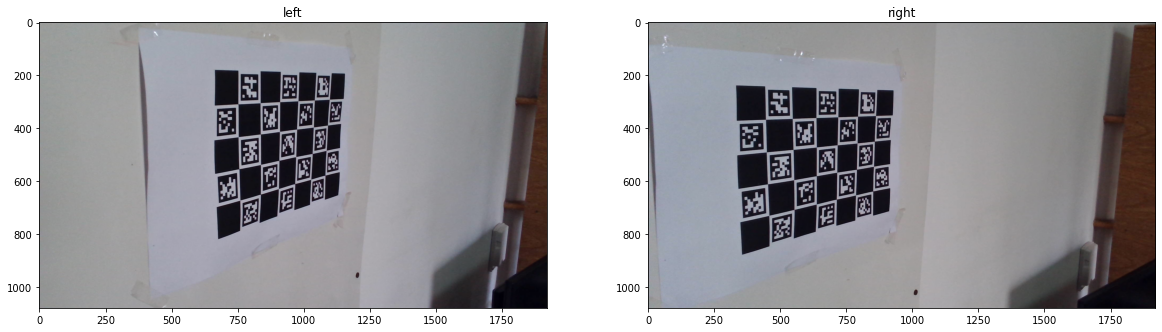

In [5]:
index = 15

im_L = PIL.Image.open(images_L[index])
im_R = PIL.Image.open(images_R[index])

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,2,1)
plt.imshow(im_L)
plt.title('left')
#ax.axis('off')

ax = fig.add_subplot(1,2,2)
plt.imshow(im_R)
plt.title('right')
#ax.axis('off')

plt.show()

## Detect corners from images

In [6]:
def read_chessboards_stereo(images_L, images_R, aruco_dict, board):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    pair_images = zip(images_L, images_R)
    
    allCorners_L = []
    allIds_L = []
    allCorners_R = []
    allIds_R = []
    skipImgs = []

    decimator = 0

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    # objp = np.zeros(((5-1)*(7-1),3), np.float32)
    # objp[:,:2] = np.mgrid[0:(7-1),0:(5-1)].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints_L = [] # 2d points in image plane.
    imgpoints_R = [] # 2d points in image plane.

    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000000, 0.0000001)

    for im_L, im_R in pair_images:
        print(f"=> Processing images: {im_L} and {im_R}")
        
        # LEFT
        frame_L = cv2.imread(im_L)
        gray_L = cv2.cvtColor(frame_L, cv2.COLOR_BGR2GRAY)

        corners_L, ids_L, rejectedImgPoints_L = cv2.aruco.detectMarkers(gray_L, aruco_dict)
        objpoint_L, imgpoint_L = cv2.aruco.getBoardObjectAndImagePoints(board, corners_L, ids_L)

        # RIGHT
        frame_R = cv2.imread(im_R)
        gray_R = cv2.cvtColor(frame_R, cv2.COLOR_BGR2GRAY)

        corners_R, ids_R, rejectedImgPoints_R = cv2.aruco.detectMarkers(gray_R, aruco_dict)
        objpoint_R, imgpoint_R = cv2.aruco.getBoardObjectAndImagePoints(board, corners_R, ids_R)

        if len(corners_L) > 0 and len(corners_R) > 0 and \
            len(imgpoint_L) == len(imgpoint_R):
            for corner in corners_L:
                cv2.cornerSubPix(gray_L, corner,
                                 winSize = (1,1), # The shorter the window the higher the accuracy
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
            for corner in corners_R:
                cv2.cornerSubPix(gray_R, corner,
                                 winSize = (1,1), # The shorter the window the higher the accuracy
                                 zeroZone = (-1,-1),
                                 criteria = criteria)

            res2_L = cv2.aruco.interpolateCornersCharuco(corners_L, ids_L, gray_L, board)
            res2_R = cv2.aruco.interpolateCornersCharuco(corners_R, ids_R, gray_R, board)

            if decimator%1==0 and \
                res2_L[1] is not None and res2_L[2] is not None and len(res2_L[1])>3 and \
                res2_R[1] is not None and res2_R[2] is not None and len(res2_R[1])>3 and \
                res2_L[1].all() == res2_R[1].all():

                allCorners_L.append(res2_L[1])
                allIds_L.append(res2_L[2])
                imgpoints_L.append(imgpoint_L)

                allCorners_R.append(res2_R[1])
                allIds_R.append(res2_R[2])
                imgpoints_R.append(imgpoint_R)

                objpoints.append(objpoint_L)

            else: 
                print(f"Skip image: {im_L} - {im_R}")
                skipImgs.append((im_L, im_R))

        else:
            print(f"Skip image: {im_L} - {im_R}")
            skipImgs.append((im_L, im_R))

        decimator+=1

    imsize = gray_L.shape

    return allCorners_L, allIds_L, allCorners_R, allIds_R, imsize, skipImgs, objpoints, imgpoints_L, imgpoints_R

In [7]:
allCorners_L, allIds_L, allCorners_R, allIds_R, imsize, skipImgs, objpoints, imgpoints_L, imgpoints_R = read_chessboards_stereo(images_L, images_R, aruco_dict, board)

POSE ESTIMATION STARTS:
=> Processing images: ./calib_cam/left/0.png and ./calib_cam/right/0.png
=> Processing images: ./calib_cam/left/1.png and ./calib_cam/right/1.png
=> Processing images: ./calib_cam/left/2.png and ./calib_cam/right/2.png
=> Processing images: ./calib_cam/left/3.png and ./calib_cam/right/3.png
=> Processing images: ./calib_cam/left/4.png and ./calib_cam/right/4.png
=> Processing images: ./calib_cam/left/5.png and ./calib_cam/right/5.png
=> Processing images: ./calib_cam/left/6.png and ./calib_cam/right/6.png
=> Processing images: ./calib_cam/left/7.png and ./calib_cam/right/7.png
=> Processing images: ./calib_cam/left/8.png and ./calib_cam/right/8.png
=> Processing images: ./calib_cam/left/9.png and ./calib_cam/right/9.png
=> Processing images: ./calib_cam/left/10.png and ./calib_cam/right/10.png
=> Processing images: ./calib_cam/left/11.png and ./calib_cam/right/11.png
=> Processing images: ./calib_cam/left/12.png and ./calib_cam/right/12.png
=> Processing images:

In [8]:
print(len(allCorners_L))
print(len(allCorners_R))
print(len(allIds_L))
print(len(allIds_R))

41
41
41
41


### Clean up poor images

In [9]:
# clean up
for skipImg in skipImgs:
    print(skipImg)
    index_L = np.where(images_L == skipImg[0])[0]
    index_R = np.where(images_R == skipImg[1])[0]

    assert index_L == index_R

    try:
        images_L = np.delete(images_L, index_L)
        images_R = np.delete(images_R, index_R)
    except BaseException as e:
        print(e)

print(len(images_L))
print(len(images_R))

('./calib_cam/left/21.png', './calib_cam/right/21.png')
('./calib_cam/left/33.png', './calib_cam/right/33.png')
('./calib_cam/left/37.png', './calib_cam/right/37.png')
('./calib_cam/left/41.png', './calib_cam/right/41.png')
('./calib_cam/left/44.png', './calib_cam/right/44.png')
41
41


In [10]:
# Check
print(images_L)
print(images_R)

['./calib_cam/left/0.png' './calib_cam/left/1.png'
 './calib_cam/left/2.png' './calib_cam/left/3.png'
 './calib_cam/left/4.png' './calib_cam/left/5.png'
 './calib_cam/left/6.png' './calib_cam/left/7.png'
 './calib_cam/left/8.png' './calib_cam/left/9.png'
 './calib_cam/left/10.png' './calib_cam/left/11.png'
 './calib_cam/left/12.png' './calib_cam/left/13.png'
 './calib_cam/left/14.png' './calib_cam/left/15.png'
 './calib_cam/left/16.png' './calib_cam/left/17.png'
 './calib_cam/left/18.png' './calib_cam/left/19.png'
 './calib_cam/left/20.png' './calib_cam/left/22.png'
 './calib_cam/left/23.png' './calib_cam/left/24.png'
 './calib_cam/left/25.png' './calib_cam/left/26.png'
 './calib_cam/left/27.png' './calib_cam/left/28.png'
 './calib_cam/left/29.png' './calib_cam/left/30.png'
 './calib_cam/left/31.png' './calib_cam/left/32.png'
 './calib_cam/left/34.png' './calib_cam/left/35.png'
 './calib_cam/left/36.png' './calib_cam/left/38.png'
 './calib_cam/left/39.png' './calib_cam/left/40.png'
 '.

In [11]:
allCorners_L, allIds_L, allCorners_R, allIds_R, imsize, skipImgs, objpoints, imgpoints_L, imgpoints_R = read_chessboards_stereo(images_L, images_R, aruco_dict, board)

POSE ESTIMATION STARTS:
=> Processing images: ./calib_cam/left/0.png and ./calib_cam/right/0.png
=> Processing images: ./calib_cam/left/1.png and ./calib_cam/right/1.png
=> Processing images: ./calib_cam/left/2.png and ./calib_cam/right/2.png
=> Processing images: ./calib_cam/left/3.png and ./calib_cam/right/3.png
=> Processing images: ./calib_cam/left/4.png and ./calib_cam/right/4.png
=> Processing images: ./calib_cam/left/5.png and ./calib_cam/right/5.png
=> Processing images: ./calib_cam/left/6.png and ./calib_cam/right/6.png
=> Processing images: ./calib_cam/left/7.png and ./calib_cam/right/7.png
=> Processing images: ./calib_cam/left/8.png and ./calib_cam/right/8.png
=> Processing images: ./calib_cam/left/9.png and ./calib_cam/right/9.png
=> Processing images: ./calib_cam/left/10.png and ./calib_cam/right/10.png
=> Processing images: ./calib_cam/left/11.png and ./calib_cam/right/11.png
=> Processing images: ./calib_cam/left/12.png and ./calib_cam/right/12.png
=> Processing images:

In [12]:
# Check
print("Left")
print(len(allCorners_L))
print("Right")
print(len(allCorners_R))
print("Skip")
print(skipImgs)

Left
41
Right
41
Skip
[]


## Calibration

In [13]:
admissible_repr_error = 1.0

In [14]:
def calibrate_camera(allCorners, allIds, imsize, skip_images = np.array([])):
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")

    cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    # flags = (cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_THIN_PRISM_MODEL + cv2.CALIB_TILTED_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)

    # Documentation (https://docs.opencv.org/4.x/d9/d6a/group__aruco.html#gadcc5dc30c9ad33dcf839e84e8638dcd1)
    (ret, camera_matrix, distortion_coefficients0,
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10 ** 6, 1e-11))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors, perViewErrors

In [15]:
print(f"Left camera")
%time ret_L, mtx_L, dist_L, rvecs_L, tvecs_L, perViewErrors_L = calibrate_camera(allCorners_L,allIds_L,imsize)

Left camera
CAMERA CALIBRATION
CPU times: total: 8.42 s
Wall time: 8.42 s


In [16]:
result_L = np.where(perViewErrors_L >= admissible_repr_error)
zip_repr_err = dict(zip(images_L[result_L[0]], perViewErrors_L[result_L[0]]))

print(f"N° of left images with high reprojection error: {len(result_L[0])}")
print(zip_repr_err)

N° of left images with high reprojection error: 17
{'./calib_cam/left/3.png': array([1.51159565]), './calib_cam/left/4.png': array([1.6508039]), './calib_cam/left/5.png': array([1.65059581]), './calib_cam/left/6.png': array([1.87872409]), './calib_cam/left/7.png': array([1.97570437]), './calib_cam/left/8.png': array([1.68760006]), './calib_cam/left/9.png': array([1.26954937]), './calib_cam/left/10.png': array([1.2489609]), './calib_cam/left/11.png': array([1.15955203]), './calib_cam/left/12.png': array([1.29415302]), './calib_cam/left/13.png': array([1.85161774]), './calib_cam/left/14.png': array([1.45287056]), './calib_cam/left/15.png': array([2.01878621]), './calib_cam/left/29.png': array([1.18322171]), './calib_cam/left/30.png': array([1.38393261]), './calib_cam/left/32.png': array([1.06425364]), './calib_cam/left/36.png': array([1.51066178])}


In [17]:
print(f"Right camera")
%time ret_R, mtx_R, dist_R, rvecs_R, tvecs_R, perViewErrors_R = calibrate_camera(allCorners_R,allIds_R,imsize)

Right camera
CAMERA CALIBRATION
CPU times: total: 8.61 s
Wall time: 8.61 s


In [18]:
result_R = np.where(perViewErrors_R >= admissible_repr_error)
zip_repr_err = dict(zip(images_R[result_R[0]], perViewErrors_R[result_R[0]]))

print(f"N° of right images with high reprojection error: {len(result_R[0])}")
print(zip_repr_err)

N° of right images with high reprojection error: 21
{'./calib_cam/right/2.png': array([1.21810216]), './calib_cam/right/3.png': array([2.37060456]), './calib_cam/right/4.png': array([2.39072064]), './calib_cam/right/5.png': array([2.40120721]), './calib_cam/right/6.png': array([2.42635923]), './calib_cam/right/7.png': array([1.78073147]), './calib_cam/right/8.png': array([1.56360863]), './calib_cam/right/9.png': array([1.08088198]), './calib_cam/right/10.png': array([1.02789629]), './calib_cam/right/11.png': array([1.39259638]), './calib_cam/right/12.png': array([1.28241412]), './calib_cam/right/13.png': array([1.6014657]), './calib_cam/right/14.png': array([1.8523123]), './calib_cam/right/15.png': array([1.79395214]), './calib_cam/right/28.png': array([1.03350393]), './calib_cam/right/29.png': array([1.19305768]), './calib_cam/right/30.png': array([1.16235391]), './calib_cam/right/32.png': array([1.0054316]), './calib_cam/right/34.png': array([1.02905339]), './calib_cam/right/35.png':

In [19]:
print(f"Reprojection error\n Left: {ret_L}\n Right: {ret_R}")

Reprojection error
 Left: 1.1476456235493169
 Right: 1.2288818165399407


In [20]:
print(f"Calibration matrix:\n Left \n{mtx_L} \n Right \n{mtx_R}")

Calibration matrix:
 Left 
[[1.81097589e+03 0.00000000e+00 1.06400395e+03]
 [0.00000000e+00 1.81097589e+03 5.31162829e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
 Right 
[[1.81056635e+03 0.00000000e+00 9.64126897e+02]
 [0.00000000e+00 1.81056635e+03 5.61601206e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [21]:
print(f"Distortion coefficients:\n Left \n{dist_L.T} \n Right \n{dist_R.T}")

Distortion coefficients:
 Left 
[[-1.84855110e+01 -1.18014099e+01 -6.05313438e-03  2.34989816e-02
   1.08943127e+03 -1.86004811e+01 -8.95173903e+00  1.07178252e+03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]] 
 Right 
[[-8.53739365e-02  1.33808723e+01  6.45071606e-04 -4.06556114e-04
   1.92611368e+02 -3.49436480e-02  1.12326118e+01  1.99216045e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


### Clean up poor data

In [22]:
# Skip this cell if this omits lot of images

counter = 0

while len(result_R[0]) > 0 or len(result_L[0]):
    print(f"\nIteration {counter}")

    allIndex = np.unique(np.concatenate((result_L[0], result_R[0])))
    allIndex = np.flip(allIndex)

    for i in allIndex:
        try:
            del allCorners_R[i]
            del allIds_R[i]
            del imgpoints_R[i]
            del allCorners_L[i]
            del allIds_L[i]
            del imgpoints_L[i]
            del objpoints[i]
        except BaseException as e:
            print(e)

    images_L = np.delete(images_L, allIndex)
    images_R = np.delete(images_R, allIndex)

    print(f"Left camera")
    %time ret_L, mtx_L, dist_L, rvecs_L, tvecs_L, perViewErrors_L = calibrate_camera(allCorners_L,allIds_L,imsize)

    result_L = np.where(perViewErrors_L >= admissible_repr_error)
    zip_repr_err = dict(zip(images_L[result_L[0]], perViewErrors_L[result_L[0]]))

    print(f"N° of left images with high reprojection error: {len(result_L[0])}")
    print(zip_repr_err)

    print(f"Right camera")
    %time ret_R, mtx_R, dist_R, rvecs_R, tvecs_R, perViewErrors_R = calibrate_camera(allCorners_R,allIds_R,imsize)

    result_R = np.where(perViewErrors_R >= admissible_repr_error)
    zip_repr_err = dict(zip(images_R[result_R[0]], perViewErrors_R[result_R[0]]))

    print(f"N° of right images with high reprojection error: {len(result_R[0])}")
    print(zip_repr_err)

    counter+=1

print(len(allCorners_R))
print(len(allCorners_L))
print(len(allIds_R))
print(len(allIds_L))
print(len(imgpoints_R))
print(len(imgpoints_L))
print(len(images_R))
print(len(images_L))


Iteration 0
Left camera
CAMERA CALIBRATION
CPU times: total: 953 ms
Wall time: 948 ms
N° of left images with high reprojection error: 0
{}
Right camera
CAMERA CALIBRATION
CPU times: total: 1.14 s
Wall time: 1.15 s
N° of right images with high reprojection error: 9
{'./calib_cam/right/1.png': array([2.17054777]), './calib_cam/right/18.png': array([1.00773794]), './calib_cam/right/22.png': array([1.27317115]), './calib_cam/right/23.png': array([1.7889818]), './calib_cam/right/24.png': array([1.28198198]), './calib_cam/right/40.png': array([1.13388903]), './calib_cam/right/42.png': array([1.09160038]), './calib_cam/right/43.png': array([1.63666952]), './calib_cam/right/45.png': array([1.45466716])}

Iteration 1
Left camera
CAMERA CALIBRATION
CPU times: total: 234 ms
Wall time: 227 ms
N° of left images with high reprojection error: 0
{}
Right camera
CAMERA CALIBRATION
CPU times: total: 219 ms
Wall time: 228 ms
N° of right images with high reprojection error: 0
{}
11
11
11
11
11
11
11
11


In [23]:
## Clean up and recalibrate

allIndex = np.unique(np.concatenate((result_L[0], result_R[0])))
allIndex = np.flip(allIndex)
allIndex

array([], dtype=int64)

In [24]:
for i in allIndex:
    try:
        del allCorners_R[i]
        del allIds_R[i]
        del imgpoints_R[i]
        del allCorners_L[i]
        del allIds_L[i]
        del imgpoints_L[i]
        del objpoints[i]
    except BaseException as e:
        print(e)

images_L = np.delete(images_L, allIndex)
images_R = np.delete(images_R, allIndex)

print(len(allCorners_R))
print(len(allCorners_L))
print(len(allIds_R))
print(len(allIds_L))
print(len(imgpoints_R))
print(len(imgpoints_L))
print(len(images_R))
print(len(images_L))

11
11
11
11
11
11
11
11


In [25]:
print(f"Left camera")
%time ret_L, mtx_L, dist_L, rvecs_L, tvecs_L, perViewErrors_L = calibrate_camera(allCorners_L,allIds_L,imsize)

Left camera
CAMERA CALIBRATION
CPU times: total: 234 ms
Wall time: 228 ms


In [26]:
result_L = np.where(perViewErrors_L >= admissible_repr_error)
zip_repr_err = dict(zip(images_L[result_L[0]], perViewErrors_L[result_L[0]]))

print(f"N° of left images with high reprojection error: {len(result_L[0])}")
print(zip_repr_err)

N° of left images with high reprojection error: 0
{}


In [27]:
print(f"Right camera")
%time ret_R, mtx_R, dist_R, rvecs_R, tvecs_R, perViewErrors_R = calibrate_camera(allCorners_R,allIds_R,imsize)

Right camera
CAMERA CALIBRATION
CPU times: total: 234 ms
Wall time: 231 ms


In [28]:
result_R = np.where(perViewErrors_R >= admissible_repr_error)
zip_repr_err = dict(zip(images_R[result_R[0]], perViewErrors_R[result_R[0]]))

print(f"N° of right images with high reprojection error: {len(result_R[0])}")
print(zip_repr_err)

N° of right images with high reprojection error: 0
{}


In [29]:
print(f"Reprojection error\n Left: {ret_L}\n Right: {ret_R}")

Reprojection error
 Left: 0.664868263246256
 Right: 0.6207018990541066


In [30]:
# Reprojection error

if False:
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        # print((imgpoints[i].shape))
        # print((imgpoints2.shape))
        if imgpoints[i].shape != imgpoints2.shape:
            print(f"Not all markers detected in img {i}")
            continue
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        # print(f"Error {i}: {error}")
        mean_error += error
    print( "total error: {}".format(mean_error/len(objpoints)) )

### Check results

In [31]:
# Refining camera matrix and check calibration results
i=5 # select image index

# LEFT
print(images_L[i])
frame_L = cv2.imread(images_L[i])
img_undist_L = cv2.undistort(frame_L, mtx_L, dist_L, None, None)

h_L, w_L = frame_L.shape[:2]
new_mtx_L, roi_L = cv2.getOptimalNewCameraMatrix(mtx_L, dist_L, (w_L,h_L), 1, (w_L,h_L))
img_undist_fine_L = cv2.undistort(frame_L, mtx_L, dist_L, None, new_mtx_L)

# crop the image
x, y, w, h = roi_L
img_undist_fine_L = img_undist_fine_L[y:y+h, x:x+w]

# RIGHT
print(images_R[i])
frame_R = cv2.imread(images_R[i])
img_undist_R = cv2.undistort(frame_R, mtx_R, dist_R, None, None)

h_R, w_R = frame_R.shape[:2]
new_mtx_R, roi_R = cv2.getOptimalNewCameraMatrix(mtx_R, dist_R, (w_R,h_R), 1, (w_R,h_R))
img_undist_fine_R = cv2.undistort(frame_R, mtx_R, dist_R, None, new_mtx_R)

# crop the image
x, y, w, h = roi_R
img_undist_fine_R = img_undist_fine_R[y:y+h, x:x+w]

./calib_cam/left/25.png
./calib_cam/right/25.png


In [32]:
print(f"Calibration matrix:\n Left \n{mtx_L} \n Right \n{mtx_R}")
print(f"Calibration matrix - Refined :\n Left \n{new_mtx_L} \n Right \n{new_mtx_R}")

Calibration matrix:
 Left 
[[2.10367454e+03 0.00000000e+00 6.66322746e+02]
 [0.00000000e+00 2.10367454e+03 6.32401114e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
 Right 
[[2.02158951e+03 0.00000000e+00 7.04047932e+02]
 [0.00000000e+00 2.02158951e+03 5.84050813e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Calibration matrix - Refined :
 Left 
[[1.95462976e+03 0.00000000e+00 5.85987767e+02]
 [0.00000000e+00 1.95678003e+03 6.47573708e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
 Right 
[[1.28632996e+03 0.00000000e+00 4.17083151e+02]
 [0.00000000e+00 1.16206042e+03 6.34773274e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


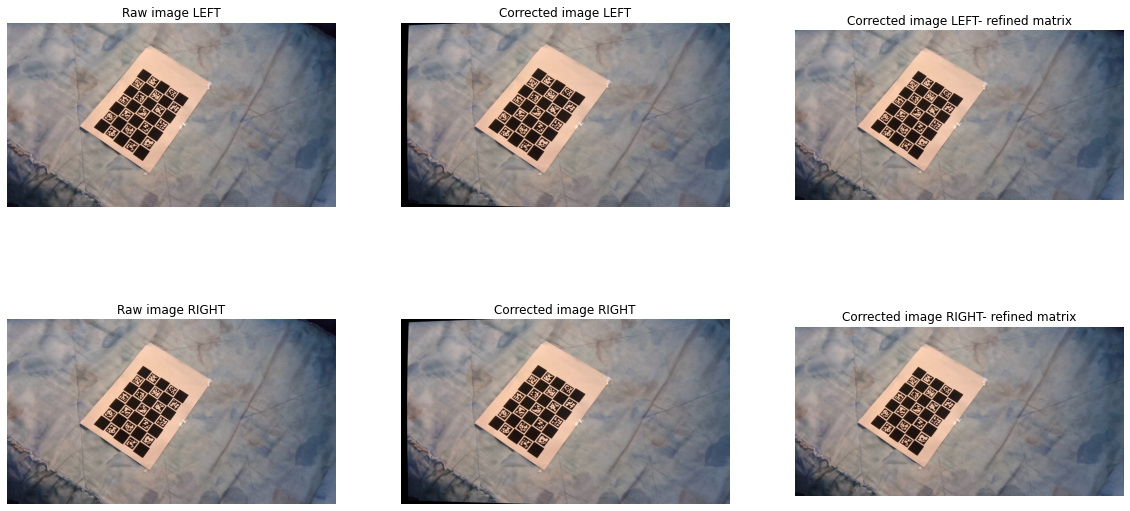

In [33]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(frame_L)
plt.title("Raw image LEFT")
plt.axis("off")
plt.subplot(2,3,2)
plt.imshow(img_undist_L)
plt.title("Corrected image LEFT")
plt.axis("off")
plt.subplot(2,3,3)
plt.imshow(img_undist_fine_L)
plt.title("Corrected image LEFT- refined matrix")
plt.axis("off")

plt.subplot(2,3,4)
plt.imshow(frame_L)
plt.title("Raw image RIGHT")
plt.axis("off")
plt.subplot(2,3,5)
plt.imshow(img_undist_L)
plt.title("Corrected image RIGHT")
plt.axis("off")
plt.subplot(2,3,6)
plt.imshow(img_undist_fine_L)
plt.title("Corrected image RIGHT- refined matrix")
plt.axis("off")

plt.show()

In [34]:
import pickle
import os

paramsdir = "./calib_params/"

# Check whether the specified path exists or not
isExist = os.path.exists(paramsdir)

if not isExist:
  os.makedirs(paramsdir)
  
pickle.dump(mtx_L, open('./calib_params/matrix_L.pickle', 'wb'))
pickle.dump(new_mtx_L, open('./calib_params/refined_matrix_L.pickle', 'wb'))
pickle.dump(dist_L, open('./calib_params/dist_coef_L.pickle', 'wb'))
pickle.dump(rvecs_L, open('./calib_params/rotation_vectors_L.pickle', 'wb'))
pickle.dump(tvecs_L, open('./calib_params/translation_vectors_L.pickle', 'wb'))
pickle.dump(ret_L, open('./calib_params/reprojection_error_L.pickle', 'wb'))

pickle.dump(mtx_R, open('./calib_params/matrix_R.pickle', 'wb'))
pickle.dump(new_mtx_R, open('./calib_params/refined_matrix_R.pickle', 'wb'))
pickle.dump(dist_R, open('./calib_params/dist_coef_R.pickle', 'wb'))
pickle.dump(rvecs_R, open('./calib_params/rotation_vectors_R.pickle', 'wb'))
pickle.dump(tvecs_R, open('./calib_params/translation_vectors_R.pickle', 'wb'))
pickle.dump(ret_R, open('./calib_params/reprojection_error_R.pickle', 'wb'))

### Use of camera calibration to estimate 3D translation and rotation of each marker on a scene

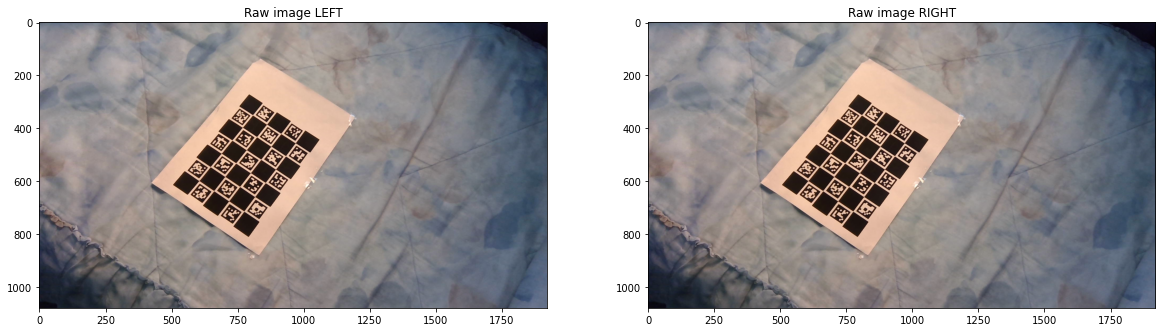

In [35]:
# frame = cv2.imread("./calib_cam_1/02_08/100.png")
#frame = cv2.undistort(src = frame, cameraMatrix = mtx, distCoeffs = dist)
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(frame_L)
plt.title("Raw image LEFT")

plt.subplot(1,2,2)
plt.imshow(frame_L)
plt.title("Raw image RIGHT")

plt.show()

In [36]:
# Post processing
parameters =  aruco.DetectorParameters_create()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)

## LEFT
gray_L = cv2.cvtColor(frame_L, cv2.COLOR_BGR2GRAY)
corners_L, ids_L, rejectedImgPoints_L = aruco.detectMarkers(gray_L, aruco_dict,
                                                      parameters=parameters)
                                                                                                        
# SUB PIXEL DETECTION
for corner in corners_L:
    cv2.cornerSubPix(gray_L, corner, winSize = (1,1), zeroZone = (-1,-1), criteria = criteria)

frame_markers_L = aruco.drawDetectedMarkers(frame_L.copy(), corners_L, ids_L)

retval_L, charucoCorners_L, charucoIds_L = cv2.aruco.interpolateCornersCharuco(corners_L, ids_L, frame_L.copy(), board, cameraMatrix=new_mtx_L, distCoeffs=dist_L)
frame_corners_L = aruco.drawDetectedCornersCharuco(frame_L.copy(), charucoCorners_L, charucoIds_L)

## RIGHT
gray_R = cv2.cvtColor(frame_R, cv2.COLOR_BGR2GRAY)
corners_R, ids_R, rejectedImgPoints_R = aruco.detectMarkers(gray_R, aruco_dict,
                                                      parameters=parameters)
                                                      
# SUB PIXEL DETECTION
for corner in corners_R:
    cv2.cornerSubPix(gray_R, corner, winSize = (1,1), zeroZone = (-1,-1), criteria = criteria)

frame_markers_R = aruco.drawDetectedMarkers(frame_R.copy(), corners_R, ids_R)

retval_R, charucoCorners_R, charucoIds_R = cv2.aruco.interpolateCornersCharuco(corners_R, ids_R, frame_R.copy(), board, cameraMatrix=new_mtx_R, distCoeffs=dist_R)
frame_corners_R = aruco.drawDetectedCornersCharuco(frame_R.copy(), charucoCorners_R, charucoIds_R)

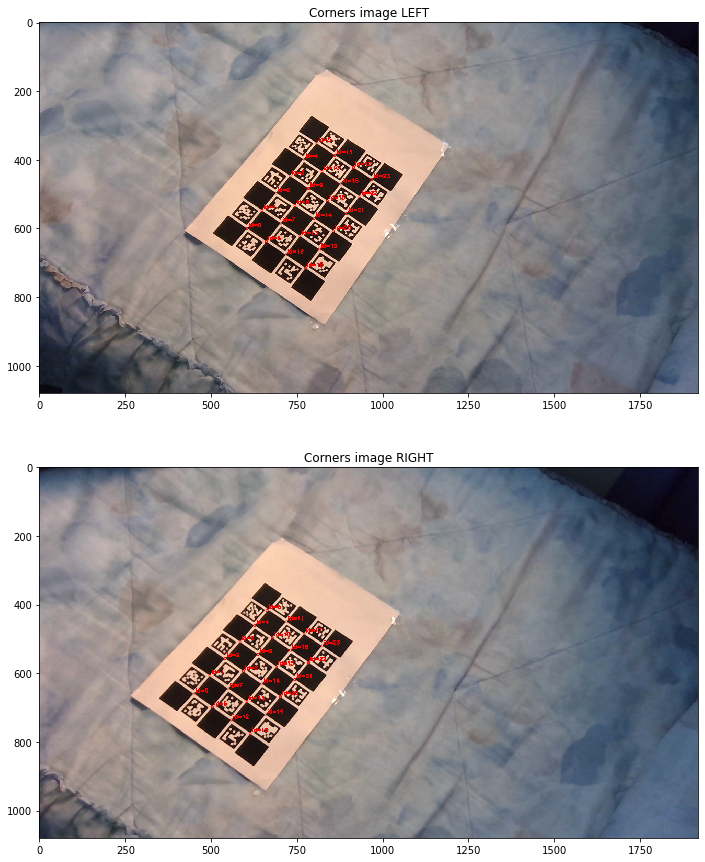

In [37]:
# Results
plt.figure(figsize=(30,15))

plt.subplot(2,1,1)
plt.imshow(frame_corners_L, interpolation = "nearest")
plt.title("Corners image LEFT")

plt.subplot(2,1,2)
plt.imshow(frame_corners_R, interpolation = "nearest")
plt.title("Corners image RIGHT")

plt.show()

Conlcusion: corner detection might be improved

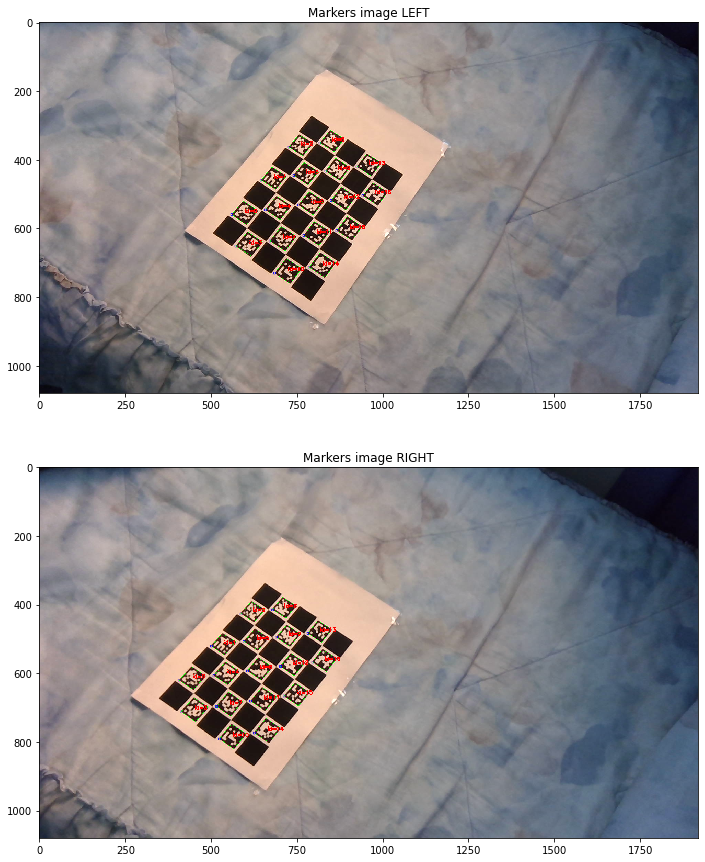

In [38]:
# Results
plt.figure(figsize=(30,15))

plt.subplot(2,1,1)
plt.imshow(frame_markers_L, interpolation = "nearest")
plt.title("Markers image LEFT")

plt.subplot(2,1,2)
plt.imshow(frame_markers_R, interpolation = "nearest")
plt.title("Markers image RIGHT")

plt.show()

### Performing stereo calibration with fixed intrinsic parameters

In [39]:
for i in range(len(objpoints)):
    if imgpoints_L[i].shape[0] == imgpoints_R[i].shape[0] and objpoints[i].shape[0] == imgpoints_L[i].shape[0]:
        continue
    else:
        print(i)
        print(imgpoints_L[i].shape)        
        print(imgpoints_R[i].shape)
        print(objpoints[i].shape)

In [40]:
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
# Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.
# Hence intrinsic parameters are the same 

criteria_stereo = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# This step is performed to transformation between the two cameras and calculate Essential and Fundamenatl matrix
retS, new_mtxL, distL, new_mtxR, distR, Rot, Trns, Emat, Fmat = cv2.stereoCalibrate(objectPoints=objpoints,
                                                                                    imagePoints1=imgpoints_L,
                                                                                    imagePoints2=imgpoints_R,
                                                                                    cameraMatrix1=new_mtx_L,
                                                                                    cameraMatrix2=new_mtx_R,
                                                                                    distCoeffs1=dist_L,
                                                                                    distCoeffs2=dist_R,
                                                                                    imageSize=imsize,
                                                                                    criteria=criteria_stereo,
                                                                                    flags=flags)

In [41]:
retS

150.4017344766096